In [1]:
import numpy as np
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from utils.data_formats import timeseries_to_channels
from simulators import Simulator
from spectralcomponents import PowerLaw, GaussianEmissionLine, Spectrum
from sbi.inference import SNRE_B, SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.neural_nets.embedding_nets import FCEmbedding, CNNEmbedding, PermutationInvariantEmbedding
from sbi_tools import BoxUniform
from sbi.inference import SNPE
from sbi.utils import posterior_nn, likelihood_nn
from matplotlib import pyplot as plt



c1 = PowerLaw()
spectrum = Spectrum(c1)

prior = BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([2, 2]))
def simulate_simple(params):
    simulator =  Simulator(spectrum, 10000, pileup='channels')
    data = simulator(params)
    return np.bincount(data, minlength=1025)[1:]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-07 11:58:38.901456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Simulate data for use in two parameter Power Law
We simulate 10k instances of 10k frames in 10 chunks. This corresponds to a total ess of 100 million frames. (I think this ismore than enough)

Prior is $\alpha\sim\text{Uniform}([0.1,1]), \beta\sim\text{Uniform}([0.1,2])$ independently

In [3]:
# simulator, prior = prepare_for_sbi(simulate_simple, prior)
# chunks = 10
# for chunk in range(1, chunks+1):
#     theta, x = simulate_for_sbi(simulator, prior, num_simulations=1000)
#     np.save(f'simulated_data/power_law/x_chunk{chunk}_power_law.npy', x)
#     np.save(f'simulated_data/power_law/theta_chunk{chunk}_power_law.npy', theta)

Running 1000 simulations.: 100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]


# NPE amortised

In [2]:
from copy import copy


def save_posterior(inference: SNPE, chunk):
    inference_copy = inference
    _ = inference_copy.train(force_first_round_loss=True)
    torch.manual_seed(0)
    posterior = inference_copy.build_posterior()
    torch.save(posterior, f'simulated_data/power_law/posterior_chunk{chunk}_power_law.pt')

In [ ]:

embedding_net = FCEmbedding(input_dim=1024, output_dim=100, num_layers=3, num_hiddens=1024)
neural_posterior = posterior_nn(
    model="maf", 
    embedding_net=embedding_net, 
    hidden_features=200, 
    num_transforms=5
)

inference = SNPE(
    prior=prior, 
    density_estimator=neural_posterior
)

chunks = 10
for chunk in range(chunks):
    theta, x = np.load(f'simulated_data/power_law/theta_chunk{chunk+1}_power_law.npy'), np.load(f'simulated_data/power_law/x_chunk{chunk+1}_power_law.npy')
    theta, x = torch.tensor(theta).float(), torch.tensor(x).float()
    _ = inference.append_simulations(theta, x, proposal=prior)
    save_posterior(inference, chunk + 1)

In [ ]:
embedding_net = FCEmbedding(input_dim=1024, output_dim=100, num_layers=3, num_hiddens=1024)
neural_posterior = posterior_nn(
    model="maf", 
    embedding_net=embedding_net, 
    hidden_features=200, 
    num_transforms=5
)

inference = SNPE(
    prior=prior, 
    density_estimator=neural_posterior
)

rounds = 10
for round in range(rounds):
    theta, x = np.load(f'simulated_data/power_law/theta_chunk{chunk+1}_power_law.npy'), np.load(f'simulated_data/power_law/x_chunk{chunk+1}_power_law.npy')
    theta, x = torch.tensor(theta).float(), torch.tensor(x).float()
    _ = inference.append_simulations(theta, x, proposal=prior)
    save_posterior(inference, chunk + 1)

In [ ]:
for chunk in range(1, chunks + 1):
    posterior = torch.load(f'simulated_data/power_law/posterior_chunk{chunk}_power_law.pt')    
    true_params = (0.5, 1.5)
    x_0 = simulate_simple(true_params)
    posterior.set_default_x(x_0)
    torch.manual_seed(0)
    samples = posterior.sample((100000,), x=x_0)
    fig, axes = analysis.pairplot(
        samples,
        limits=[[0.1, 1], [0.1, 2]],
        ticks=[[0.1, 1], [0.1, 2]],
        figsize=(5, 5),
        points=true_params,
        points_offdiag={"markersize": 6},
        points_colors="r",
        labels=[r"$\alpha$",r"$\beta$"],
        title=f"{chunk}k simulations",
    )
    fig.savefig(f'simulated_data/power_law/plots/post_alpha_{chunk}ksims_{true_params[0]}_beta_{true_params[1]}.png')

In [3]:
from tqdm import tqdm

def evaluate_confidence_intervals(posterior, simulate_func, total_trials, confidence_intervals, n_samples=1000, true_params=None, prior=None):
    if true_params is None:
        true_params = prior.sample()
    num_params = len(true_params)
    total_correct = np.zeros((len(confidence_intervals), num_params))
    
    for _ in tqdm(range(total_trials)):
        x_0 = simulate_func(true_params)
        posterior.set_default_x(x_0)
        samples = posterior.sample((n_samples,), x=x_0, show_progress_bars=False)
        
        for i, ci in enumerate(confidence_intervals):
            lower_bounds = np.percentile(samples, 100 * (ci/2), axis=0)
            upper_bounds = np.percentile(samples, 100 * (1 - (ci/2)), axis=0)
            
            # Check if true parameters are within the bounds for each parameter
            in_interval = (lower_bounds < true_params) & (true_params < upper_bounds)
            
            # Sum up the counts for each parameter
            total_correct[i] += in_interval

    # Normalize to get frequencies
    correct_freq = total_correct / total_trials
    return correct_freq

In [2]:
posterior = torch.load('simulated_data/power_law/posterior_chunk10_power_law.pt')
#evaluate_confidence_intervals(posterior, simulate_simple, 100, np.array([0.05, 0.33, 0.5]), true_params=(0.5,1.5), prior=prior)

In [28]:

posterior.log_prob(torch.tensor([0.5, 1.5]), x=simulate_simple((0.5, 1.5)))

tensor([-1271.7990])

# NLE amortised

In [25]:

embedding_net = FCEmbedding(input_dim=1024, output_dim=200, num_layers=3, num_hiddens=1024)
neural_likelihood = likelihood_nn(
    model="maf", 
    hidden_features=200, 
    num_transforms=5
)

mcmc_parameters = {"num_chains": 20,
                   "thin": 5}

inference = SNLE(
    prior=prior, 
    density_estimator=neural_likelihood,
    embedding_net=embedding_net
)

chunks = 10
for chunk in range(chunks):
    theta, x = np.load(f'simulated_data/power_law/theta_chunk{chunk+1}_power_law.npy'), np.load(f'simulated_data/power_law/x_chunk{chunk+1}_power_law.npy')
    theta, x = torch.tensor(theta).float(), torch.tensor(x).float()
    _ = inference.append_simulations(theta, x)
_ = inference.train()
posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
                                      mcmc_parameters=mcmc_parameters)

 Neural network successfully converged after 89 epochs.

In [37]:
posterior = torch.load('simulated_data/power_law/posterior_nle_power_law.pt')
posterior.log_prob(torch.tensor([0.5, 1.5]), x=simulate_simple((2.0, 1.5)))
#evaluate_confidence_intervals(posterior, simulate_simple, 100, np.array([0.05, 0.33, 0.5]), true_params=(0.5,1.5), prior=prior, n_samples=100)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:172: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the
            log-probability up to a normalizing constant. Use `.potential()` instead.
  warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:176: UserWarning: The log-probability is unnormalized!
  warn("The log-probability is unnormalized!")


tensor([-3881.8169])

# SNLE

In [20]:
embedding_net = FCEmbedding(input_dim=1024, output_dim=200, num_layers=3, num_hiddens=1024)
neural_likelihood = likelihood_nn(
    model="maf", 
    hidden_features=200, 
    num_transforms=5
)

mcmc_parameters = {"num_chains": 20,
                   "thin": 5}

inference = SNLE(
    prior=prior, 
    density_estimator=neural_likelihood
)

rounds = 10
num_sims = 1000

simulator, prior = prepare_for_sbi(simulate_simple, prior)
proposal = prior
for round in range(rounds):
    theta, x = simulate_for_sbi(simulator, proposal=proposal, num_simulations=num_sims)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
                                      mcmc_parameters=mcmc_parameters)
    proposal = posterior
torch.save(posterior, 'simulated_data/power_law/posterior_snle_power_law.pt')

Running 1000 simulations.:  12%|█▏        | 116/1000 [00:56<07:08,  2.06it/s]


KeyboardInterrupt: 

In [34]:

from sbi.inference import SNRE_A
embedding_net = FCEmbedding(input_dim=1024, output_dim=200, num_layers=3, num_hiddens=1024)


inference = SNRE_A(
    prior=prior, 
    classifier='resnet',
)

chunks = 10
for chunk in range(chunks):
    theta, x = np.load(f'simulated_data/power_law/theta_chunk{chunk+1}_power_law.npy'), np.load(f'simulated_data/power_law/x_chunk{chunk+1}_power_law.npy')
    theta, x = torch.tensor(theta).float(), torch.tensor(x).float()
    _ = inference.append_simulations(theta, x)
_ = inference.train()
posterior = inference.build_posterior()
torch.save(posterior, 'simulated_data/power_law/posterior_nre_a_power_law.pt')

 Neural network successfully converged after 77 epochs.

In [42]:
posterior = torch.load('simulated_data/power_law/posterior_nre_a_power_law.pt')
posterior.log_prob(torch.tensor([0.5, 1.5]), x=simulate_simple((10, 1.5)))
#evaluate_confidence_intervals(posterior, simulate_simple, 100, np.array([0.05, 0.33, 0.5]), true_params=(0.5,1.5), prior=prior, n_samples=100)

tensor([-37.7201])

# FOUR PARAMETERS


In [3]:
from spectralcomponents import DeltaEmissionLine


c1 = PowerLaw()
c2 = DeltaEmissionLine()
prior = BoxUniform(low=torch.tensor([0.1, 0.1, 5, 0.3]), 
                    high=torch.tensor([1, 2, 10, 11]))
simulator, prior = prepare_for_sbi(simulate_simple, prior)
chunks = 10
for chunk in range(1, chunks+1):
    theta, x = simulate_for_sbi(simulator, prior, num_simulations=10000)
    np.save(f'simulated_data/power_law_emission_line/x_chunk{chunk}_power_law_emission_line.npy', x)
    np.save(f'simulated_data/power_law_emission_line/theta_chunk{chunk}_power_law_emission_line.npy', theta)


Running 10000 simulations.: 100%|██████████| 10000/10000 [52:04<00:00,  3.20it/s] 


In [4]:
true_params = (0.3, 1, 8, 5)
x_0 = simulate_simple(true_params)

embedding_net = FCEmbedding(input_dim=1024, output_dim=40, num_layers=3, num_hiddens=1024)
neural_posterior = posterior_nn(
    model="maf", 
    embedding_net=embedding_net, 
    hidden_features=400,
    num_transforms=5
)

inference = SNPE(
    prior=prior, 
    density_estimator=neural_posterior
)

for chunk in range(1, chunks+1):
    theta, x = np.load(f'simulated_data/power_law_emission_line/theta_chunk{chunk}_power_law_emission_line.npy'), np.load(f'simulated_data/power_law_emission_line/x_chunk{chunk}_power_law_emission_line.npy')
    theta, x = torch.tensor(theta).float(), torch.tensor(x).float()
    _ = inference.append_simulations(theta, x, proposal=prior)
_ = inference.train()
posterior = inference.build_posterior().set_default_x(x_0)
torch.save(posterior, 'simulated_data/power_law_emission_line/posterior.pt')

 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples: 10870it [00:04, 2501.34it/s]                          


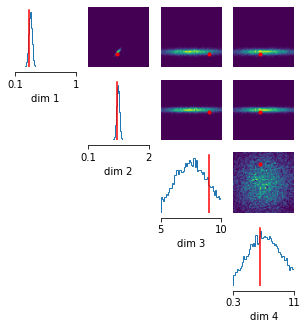

In [6]:
true_params = (0.3, 1, 9, 5)
x_0 = simulate_simple(true_params)
posterior = posterior.set_default_x(x_0)
samples = posterior.sample((10000,), x=x_0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 1,], [0.1, 2], [5, 10], [0.3, 11]],
    ticks=[[0.1, 1], [0.1, 2], [5, 10], [0.3, 11]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

In [5]:
posterior = torch.load('simulated_data/power_law_emission_line/posterior.pt')
true_params = np.array([0.3, 1, 9, 5])
evaluate_confidence_intervals(posterior, simulate_simple, 1000, np.array([0.05, 0.33, 0.5]), true_params=true_params, prior=prior, n_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [17:37<00:00,  1.06s/it]


array([[0.969, 0.964, 1.   , 1.   ],
       [0.737, 0.694, 0.   , 1.   ],
       [0.555, 0.521, 0.   , 1.   ]])

In [3]:
embedding_net = FCEmbedding(input_dim=1024, output_dim=100, num_layers=3, num_hiddens=1024)
neural_posterior = posterior_nn(
    model="nsf", 
    embedding_net=embedding_net, 
    hidden_features=200, 
    num_transforms=5
)

inference = SNPE(
    prior=prior, 
    density_estimator=neural_posterior
)

chunks = 10
for chunk in range(chunks):
    theta, x = np.load(f'simulated_data/power_law/theta_chunk{chunk+1}_power_law.npy'), np.load(f'simulated_data/power_law/x_chunk{chunk+1}_power_law.npy')
    theta, x = torch.tensor(theta).float(), torch.tensor(x).float()
    _ = inference.append_simulations(theta, x, proposal=prior)

In [4]:
_ = inference.train()
true_params = (0.5, 1.5)
x0 = simulate_simple(true_params)
posterior = inference.build_posterior().set_default_x(x0)

 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples: 10086it [00:01, 7280.04it/s]                          


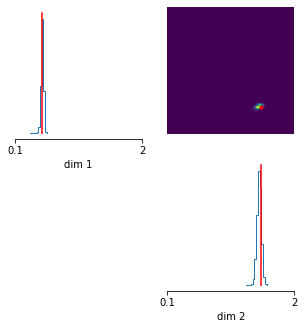

In [8]:
samples = posterior.sample((10000,), x=x0)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.1, 2,], [0.1, 2]],
    ticks=[[0.1, 2], [0.1, 2]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
)

In [9]:
from pileup.analytical import TruePosterior

In [10]:
trueposterior = TruePosterior(prior=prior, spectrum=spectrum, obs=x0, pileup='channels')

In [11]:
alpha_grid = np.linspace(0.05, 2, 200)
beta_grid = np.linspace(0.05, 2, 200)
out = trueposterior.compute_grid_posterior(alpha_grid, beta_grid).T


Computing posterior:   0%|          | 0/200 [00:00<?, ?it/s]/Users/sebastiandixon/Documents/_M4R/pileup/classical_inference.py:132: RuntimeWarning: invalid value encountered in log
  log_likelihood_of_x0 += np.log(likelihood[x])
/Users/sebastiandixon/Documents/_M4R/pileup/classical_inference.py:132: RuntimeWarning: divide by zero encountered in log
  log_likelihood_of_x0 += np.log(likelihood[x])
/Users/sebastiandixon/Documents/_M4R/pileup/classical_inference.py:156: RuntimeWarning: invalid value encountered in subtract
  posterior = np.exp(posterior - np.max(posterior))


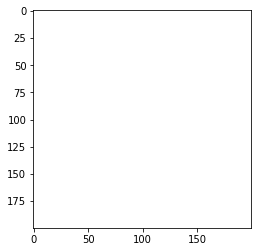

In [12]:
plt.imshow(out)